In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from toolkit import slice_spectrum, concatenate_spectra, bands_TiO, match_spectra, SimpleSpectrum
import astropy.units as u
from scipy.optimize import fmin_l_bfgs_b

In [2]:
def plot_spliced_spectrum(observed_spectrum, model_flux, other_model=None):
    n_chunks = len(observed_spectrum.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds
        
        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       0.025*np.ones(max_ind-min_ind))
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   model_flux[min_ind:max_ind])
        
        if other_model is not None:
            ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                       other_model[min_ind:max_ind], alpha=0.4)
        
        ax[i].set_xlim([observed_spectrum.wavelength[min_ind].value,
                        observed_spectrum.wavelength[max_ind-1].value])
        ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                        1.1])

    return fig, ax

In [3]:
import h5py

archive = h5py.File('/Users/bmmorris/git/aesop/notebooks/spectra.hdf5', 'r+')

In [38]:
list(archive['KIC9652680'])

['2016-07-03T09:14:11.070',
 '2016-07-03T09:36:43.800',
 '2016-07-03T09:59:17.010',
 '2016-07-03T10:22:00.230',
 '2016-07-05T09:13:14.280',
 '2016-07-05T09:35:46.510',
 '2016-07-05T09:58:18.760',
 '2016-07-05T10:20:50.890',
 '2016-07-06T09:48:27.790',
 '2016-07-06T10:06:00.510',
 '2016-07-07T08:06:49.040',
 '2016-07-07T08:29:21.170',
 '2016-07-07T08:51:54.290',
 '2017-09-11T02:20:06.990',
 '2017-09-11T06:58:36.572']

In [39]:
targets = list(archive)
# spectrum1 = archive['HATP11']['2017-06-12T07:28:06.310'] # K4
spectrum1 = archive['KIC9652680']['2016-07-05T09:58:18.760']
wavelength1 = spectrum1['wavelength'][:]
flux1 = spectrum1['flux'][:]
target = SimpleSpectrum(wavelength1, flux1, dispersion_unit=u.Angstrom)

spec_band = []

first_n_bands = 5
width = 3

for band in bands_TiO[:first_n_bands]:
    target_slice = slice_spectrum(target, band.min-width*u.Angstrom, band.max+width*u.Angstrom)
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

target_slices = concatenate_spectra(spec_band)

In [40]:
def chi2(p, target, comp):
    res, lam_offset0, lam_offset1, lam_offset2, lam_offset3, lam_offset4 = p
    lam_offsets = [lam_offset0, lam_offset1, lam_offset2, lam_offset3, lam_offset4]
    model, residuals = match_spectra(target, comp, res, *lam_offsets)
    return residuals

In [44]:
from astropy.utils.console import ProgressBar
bfgs_options_fast = dict(epsilon=1e-3, approx_grad=True,
                         m=10, maxls=20)
bfgs_options_precise = dict(epsilon=1e-3, approx_grad=True,
                            m=30, maxls=50)

target_list = []
time_list = []
residuals_list = []
counter = 0
for target in archive: 
    for time in archive[target]:
        counter +=1 

for target in archive: 
    for time in archive[target]:
        if target != 'HATP11' and target != 'KIC9652680':
            spectrum2 = archive[target][time]
            wavelength2 = spectrum2['wavelength'][:]
            flux2 = spectrum2['flux'][:]
            source1 = SimpleSpectrum(wavelength2, flux2, dispersion_unit=u.Angstrom)

            spec_band = []
            for band, inds in zip(bands_TiO[:first_n_bands], target_slices.wavelength_splits):
                target_slice = slice_spectrum(source1, band.min-width*u.Angstrom, band.max+width*u.Angstrom, 
                                              force_length=abs(np.diff(inds))[0])
                target_slice.flux /= target_slice.flux.max()
                spec_band.append(target_slice)

            source1_slices = concatenate_spectra(spec_band)

            bounds = [[0, 15]] + first_n_bands*[[-2, 2]]
            initp = [1] + first_n_bands*[0.0]

            result = fmin_l_bfgs_b(chi2, initp, bounds=bounds, 
                                   args=(target_slices, source1_slices),
                                   **bfgs_options_precise)

            model, resid = match_spectra(target_slices, source1_slices, *result[0])

            target_list.append(target)
            time_list.append(time)
            residuals_list.append(resid)
            print(target, resid)

51Peg 0.385757983785
51Peg 0.386618015077
51Peg 0.278665090089
51Peg 0.374617688785
GJ4099 6.35047138017
GJ4099 7.12839188791
GJ702B 0.771333669703
GJ9781A 0.755567615678
HD10697 0.29876935786
HD110833 0.40522769362
HD110833 0.406918294623
HD113827 0.410590985702
HD122120 0.468290698994
HD127506 0.38514114596
HD129333 0.323613218884
HD134319 0.331070695635
HD14039 1.88538204634
HD14039 10.5749426894
HD148467 0.573988301075
HD149957 0.904608689068
HD151288 0.741850550645
HD175742 0.324207623461
HD178126 1.85522759496
HD182488 0.374818847887
HD182488 0.559218299149
HD182488 0.542701428691


/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/signal/windows.py:1217: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-n ** 2 / sig2)


HD182488 0.546059193141
HD200560 0.415019617149
HD209290 2.25008119985
HD210277 0.600745252185
HD210277 0.405322782477
HD220182 0.331620063888
HD221639 2.9105974473
HD221639 0.58165870667
HD222107 0.431685621247
HD222107 0.353108483519
HD266611 0.9179654678
HD266611 0.929168450569
HD266611 0.892605577163
HD34411 0.399294407818
HD34411 0.373932785973
HD38230 0.348217438118
HD38230 0.390620326158
HD39587 0.308292334486
HD39587 0.306795375353
HD41593 0.370110360149
HD41593 0.347943019975
HD42250 0.369178090803
HD42250 0.35921014139
HD42250 0.361478846168
HD42250 0.366369998509
HD45088 0.434945138174
HD45088 0.435170219096
HD47752 0.388599322679
HD47752 0.388130029005
HD47752 0.402948348723
HD47752 0.401224217797
HD50692 0.300739569978
HD5857 0.415605654927
HD62613 0.281150514062
HD6497 0.678439585756
HD6497 0.652495707641
HD67767 0.396366455228
HD67767 0.389802157599
HD68017 0.370062094556
HD68017 0.361814467887
HD73667 0.31773265794
HD79555 0.650250694278
HD79555 0.391539265832
HD79555 0

In [45]:
first_percentile = np.percentile(residuals_list, 2)

In [46]:
for target, time, resid, in zip(target_list, time_list, residuals_list):
    if first_percentile > resid: 
        print(target, time, resid)

51Peg 2017-09-11T01:56:48.809 0.278665090089
HD89744 2017-11-06T09:45:40.470 0.276895642888


[ 5.34280403 -0.03849001 -0.30231088 -0.10503796 -0.04063689 -0.02378211]


(<matplotlib.figure.Figure at 0x1192e1048>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x118f0c320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118ef8dd8>], dtype=object))

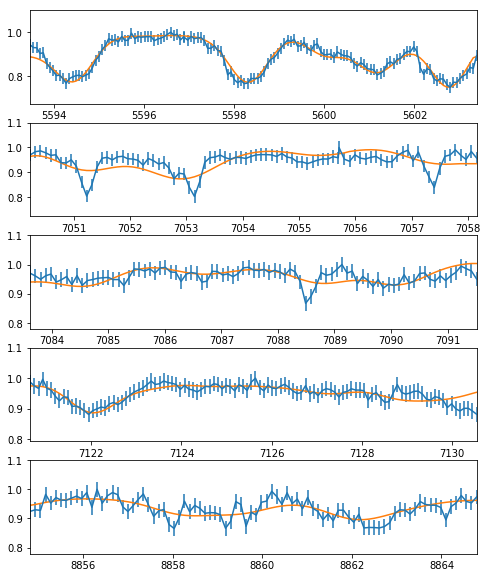

In [53]:
# target = 'HD89744'
# time = '2017-11-06T09:45:40.470'

target = '51Peg'
time = '2017-09-11T01:56:48.809'

spectrum2 = archive[target][time]
wavelength2 = spectrum2['wavelength'][:]
flux2 = spectrum2['flux'][:]
source1 = SimpleSpectrum(wavelength2, flux2, dispersion_unit=u.Angstrom)

spec_band = []
for band, inds in zip(bands_TiO[:first_n_bands], target_slices.wavelength_splits):
    target_slice = slice_spectrum(source1, band.min-width*u.Angstrom, band.max+width*u.Angstrom, 
                                  force_length=abs(np.diff(inds))[0])
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

source1_slices = concatenate_spectra(spec_band)

bounds = [[0, 15]] + first_n_bands*[[-2, 2]]
initp = [1] + first_n_bands*[-0.2]

result = fmin_l_bfgs_b(chi2, initp, bounds=bounds, 
                       args=(target_slices, source1_slices),
                       **bfgs_options_precise)

model, resid = match_spectra(target_slices, source1_slices, *result[0])

print(result[0])

plot_spliced_spectrum(target_slices, model)